Deep Learning Fundamentals - Assignment 2 - CNNs for Image Classification - Aman Sami - A1897314

100%|██████████| 170498071/170498071 [00:02<00:00, 62555535.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


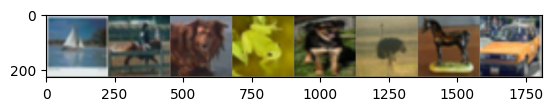

Labels: ship horse dog frog dog bird horse automobile


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, alexnet, mobilenet_v2
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

def imshow(img):
    img = img * torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))

classes = trainset.dataset.classes
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))

In [2]:
learning_rate = 0.001
batch_size = 64
num_epochs = 50
patience = 5

def baseline_evaluation(model, trainloader, valloader, testloader, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    early_stop_counter = 0

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct_train, total_train, running_loss_train = 0, 0, 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss.append(running_loss_train / len(trainloader))
        train_acc.append(100 * correct_train / total_train)

        model.eval()
        correct_val, total_val, running_loss_val = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss_epoch = running_loss_val / len(valloader)
        val_acc_epoch = 100 * correct_val / total_val
        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, "
              f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.2f}%")

        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'Train vs Validation Accuracy ({model.__class__.__name__})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Train vs Validation Loss ({model.__class__.__name__})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy of {model.__class__.__name__}: {test_accuracy:.2f}%")
    return test_accuracy


Evaluating ResNet-18 Baseline:
Epoch 1/50 - Train Loss: 1.3916, Train Acc: 49.37%, Val Loss: 1.1035, Val Acc: 60.75%
Epoch 2/50 - Train Loss: 0.8631, Train Acc: 69.42%, Val Loss: 0.8594, Val Acc: 70.74%
Epoch 3/50 - Train Loss: 0.6542, Train Acc: 77.13%, Val Loss: 0.8293, Val Acc: 72.24%
Epoch 4/50 - Train Loss: 0.5191, Train Acc: 82.02%, Val Loss: 0.6970, Val Acc: 76.83%
Epoch 5/50 - Train Loss: 0.4164, Train Acc: 85.50%, Val Loss: 0.5742, Val Acc: 80.85%
Epoch 6/50 - Train Loss: 0.3307, Train Acc: 88.30%, Val Loss: 0.5894, Val Acc: 81.03%
Epoch 7/50 - Train Loss: 0.2462, Train Acc: 91.44%, Val Loss: 0.6773, Val Acc: 80.10%
Epoch 8/50 - Train Loss: 0.1755, Train Acc: 93.87%, Val Loss: 0.9512, Val Acc: 75.55%
Epoch 9/50 - Train Loss: 0.1245, Train Acc: 95.58%, Val Loss: 0.6061, Val Acc: 82.83%
Epoch 10/50 - Train Loss: 0.0975, Train Acc: 96.59%, Val Loss: 0.7245, Val Acc: 81.48%
Early stopping triggered!


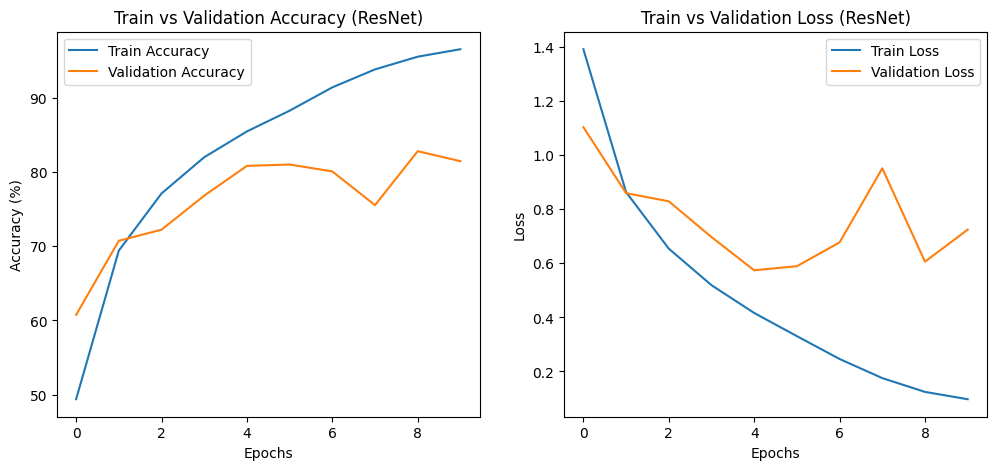

Test Accuracy of ResNet: 80.82%


In [3]:
resnet_model = resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10) 
print("\nEvaluating ResNet-18 Baseline:")
resnet_test_accuracy = baseline_evaluation(resnet_model, trainloader, valloader, testloader, device)


Evaluating AlexNet Baseline:
Epoch 1/50 - Train Loss: 1.7401, Train Acc: 35.55%, Val Loss: 1.5213, Val Acc: 43.02%
Epoch 2/50 - Train Loss: 1.4409, Train Acc: 47.44%, Val Loss: 1.3846, Val Acc: 49.66%
Epoch 3/50 - Train Loss: 1.2983, Train Acc: 53.31%, Val Loss: 1.1559, Val Acc: 60.02%
Epoch 4/50 - Train Loss: 1.1995, Train Acc: 57.30%, Val Loss: 1.0638, Val Acc: 62.62%
Epoch 5/50 - Train Loss: 1.1107, Train Acc: 60.83%, Val Loss: 1.0706, Val Acc: 61.23%
Epoch 6/50 - Train Loss: 1.0529, Train Acc: 62.82%, Val Loss: 0.9930, Val Acc: 65.42%
Epoch 7/50 - Train Loss: 1.0057, Train Acc: 64.77%, Val Loss: 0.9687, Val Acc: 66.36%
Epoch 8/50 - Train Loss: 0.9520, Train Acc: 66.49%, Val Loss: 0.9374, Val Acc: 66.81%
Epoch 9/50 - Train Loss: 0.9160, Train Acc: 68.08%, Val Loss: 0.9272, Val Acc: 67.70%
Epoch 10/50 - Train Loss: 0.8875, Train Acc: 69.17%, Val Loss: 0.9130, Val Acc: 68.42%
Epoch 11/50 - Train Loss: 0.8548, Train Acc: 70.16%, Val Loss: 0.8997, Val Acc: 68.63%
Epoch 12/50 - Train Lo

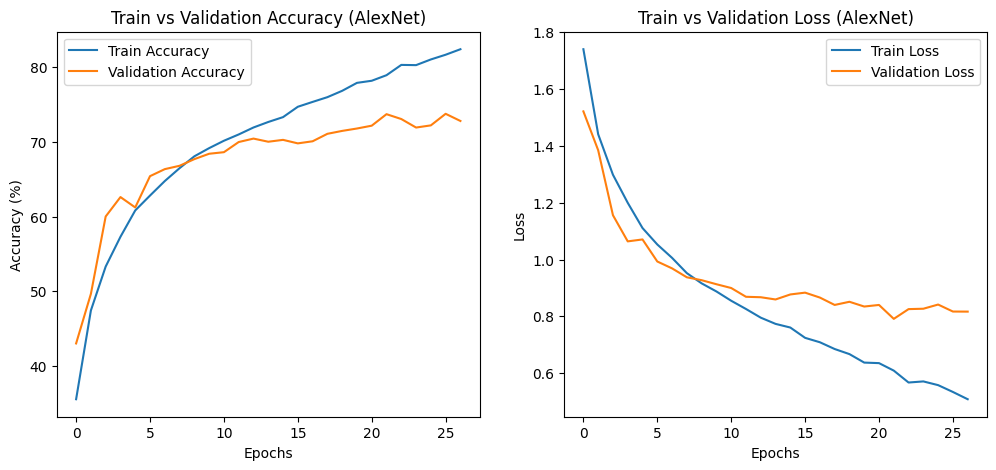

Test Accuracy of AlexNet: 72.18%


In [4]:
alexnet_model = alexnet(weights=None)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, 10)
print("\nEvaluating AlexNet Baseline:")
alexnet_test_accuracy = baseline_evaluation(alexnet_model, trainloader, valloader, testloader, device)


Evaluating MobileNetV2 Baseline:
Epoch 1/50 - Train Loss: 1.4501, Train Acc: 46.83%, Val Loss: 1.2291, Val Acc: 56.76%
Epoch 2/50 - Train Loss: 0.9815, Train Acc: 65.38%, Val Loss: 0.9601, Val Acc: 66.22%
Epoch 3/50 - Train Loss: 0.7669, Train Acc: 73.08%, Val Loss: 0.7335, Val Acc: 74.53%
Epoch 4/50 - Train Loss: 0.6284, Train Acc: 78.14%, Val Loss: 0.7452, Val Acc: 74.54%
Epoch 5/50 - Train Loss: 0.5301, Train Acc: 81.58%, Val Loss: 0.6459, Val Acc: 78.18%
Epoch 6/50 - Train Loss: 0.4595, Train Acc: 84.17%, Val Loss: 0.6363, Val Acc: 79.06%
Epoch 7/50 - Train Loss: 0.3927, Train Acc: 86.31%, Val Loss: 0.5244, Val Acc: 82.81%
Epoch 8/50 - Train Loss: 0.3390, Train Acc: 88.04%, Val Loss: 0.5634, Val Acc: 81.64%
Epoch 9/50 - Train Loss: 0.2876, Train Acc: 89.93%, Val Loss: 0.5301, Val Acc: 82.93%
Epoch 10/50 - Train Loss: 0.2508, Train Acc: 91.04%, Val Loss: 0.6538, Val Acc: 81.06%
Epoch 11/50 - Train Loss: 0.2159, Train Acc: 92.28%, Val Loss: 0.5345, Val Acc: 83.95%
Epoch 12/50 - Trai

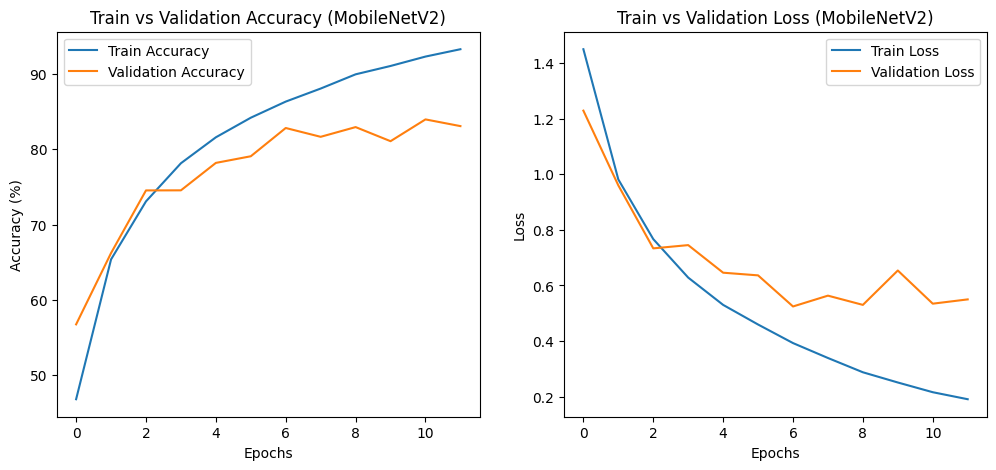

Test Accuracy of MobileNetV2: 83.30%


In [5]:
mobilenet_model = mobilenet_v2(weights=None)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, 10)
print("\nEvaluating MobileNetV2 Baseline:")
mobilenet_test_accuracy = baseline_evaluation(mobilenet_model, trainloader, valloader, testloader, device)

In [6]:
baseline_results = {
    "ResNet-18": resnet_test_accuracy,
    "AlexNet": alexnet_test_accuracy,
    "MobileNetV2": mobilenet_test_accuracy
}

best_model = max(baseline_results, key=baseline_results.get)
print("\nBaseline Comparison:")
for model_name, accuracy in baseline_results.items():
    print(f"{model_name}: Test Accuracy = {accuracy:.2f}%")
print(f"\nBest Baseline Model: {best_model} with Accuracy = {baseline_results[best_model]:.2f}%")


Baseline Comparison:
ResNet-18: Test Accuracy = 80.82%
AlexNet: Test Accuracy = 72.18%
MobileNetV2: Test Accuracy = 83.30%

Best Baseline Model: MobileNetV2 with Accuracy = 83.30%


In [7]:
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'optimizer': ['Adam', 'SGD'],
}

In [8]:
patience = 5

def train_and_evaluate(trainloader, valloader, model, optimizer, scheduler, criterion, num_epochs=50):
    best_val_loss = float('inf')
    early_stop_counter = 0
    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        correct_train, total_train, running_loss_train = 0, 0, 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        model.eval()
        correct_val, total_val, running_loss_val = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss_val / len(valloader)
        val_acc = 100 * correct_val / total_val

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered!")
                break

        if scheduler:
            scheduler.step()

    return best_val_acc

In [9]:
def hyperparameter_tuning(model, model_name, trainset, valset, device, param_grid, fixed_batch_size=64):
    results = {
        "model": model_name,
        "best_val_acc": 0,
        "best_params": {}
    }
    
    criterion = nn.CrossEntropyLoss()

    for lr in param_grid['learning_rate']:
        for opt_name in param_grid['optimizer']:
            print(f"\nTesting configuration: Model={model_name}, LR={lr}, Optimizer={opt_name}, Batch Size={fixed_batch_size}")

            trainloader = DataLoader(trainset, batch_size=fixed_batch_size, shuffle=True, num_workers=4, pin_memory=True)
            valloader = DataLoader(valset, batch_size=fixed_batch_size, shuffle=False, num_workers=4, pin_memory=True)

            model_instance = model.to(device)
            
            if opt_name == 'Adam':
                optimizer = optim.Adam(model_instance.parameters(), lr=lr)
                scheduler = None
            else:
                optimizer = optim.SGD(model_instance.parameters(), lr=lr, momentum=0.9)
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

            val_acc = train_and_evaluate(trainloader, valloader, model_instance, optimizer, scheduler, criterion, num_epochs=50)

            if val_acc > results["best_val_acc"]:
                results["best_val_acc"] = val_acc
                results["best_params"] = {'learning_rate': lr, 'optimizer': opt_name, 'batch_size': fixed_batch_size}

            print(f"Validation Accuracy for this config: {val_acc:.2f}%")

    print(f"\nBest Hyperparameters for {model_name}:")
    print(results["best_params"])
    print(f"Best Validation Accuracy for {model_name}: {results['best_val_acc']:.2f}%")

    return results

In [10]:
resnet_model = resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
print("\nOptimizing ResNet-18:")
resnet_results = hyperparameter_tuning(resnet_model, "ResNet-18", trainset, valset, device, param_grid)


Optimizing ResNet-18:

Testing configuration: Model=ResNet-18, LR=0.001, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 79.80%

Testing configuration: Model=ResNet-18, LR=0.001, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 85.48%

Testing configuration: Model=ResNet-18, LR=0.0005, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 84.63%

Testing configuration: Model=ResNet-18, LR=0.0005, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 85.55%

Testing configuration: Model=ResNet-18, LR=0.0001, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 86.45%

Testing configuration: Model=ResNet-18, LR=0.0001, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 86.49%

Best Hyperparameters for ResNet-18:
{'learning_rate': 0.0001, 'optimi

In [11]:
alexnet_model = alexnet(weights=None)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, 10)
print("\nOptimizing AlexNet:")
alexnet_results = hyperparameter_tuning(alexnet_model, "AlexNet", trainset, valset, device, param_grid)


Optimizing AlexNet:

Testing configuration: Model=AlexNet, LR=0.001, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 71.79%

Testing configuration: Model=AlexNet, LR=0.001, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 73.89%

Testing configuration: Model=AlexNet, LR=0.0005, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 73.97%

Testing configuration: Model=AlexNet, LR=0.0005, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 74.43%

Testing configuration: Model=AlexNet, LR=0.0001, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 74.73%

Testing configuration: Model=AlexNet, LR=0.0001, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 74.90%

Best Hyperparameters for AlexNet:
{'learning_rate': 0.0001, 'optimizer': 'SGD', 'ba

In [12]:
mobilenet_model = mobilenet_v2(weights=None)
mobilenet_model.classifier[1] = nn.Linear(mobilenet_model.classifier[1].in_features, 10)
print("\nOptimizing MobileNetV2:")
mobilenet_results = hyperparameter_tuning(mobilenet_model, "MobileNetV2", trainset, valset, device, param_grid)


Optimizing MobileNetV2:

Testing configuration: Model=MobileNetV2, LR=0.001, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 82.86%

Testing configuration: Model=MobileNetV2, LR=0.001, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 87.31%

Testing configuration: Model=MobileNetV2, LR=0.0005, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 85.24%

Testing configuration: Model=MobileNetV2, LR=0.0005, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 87.06%

Testing configuration: Model=MobileNetV2, LR=0.0001, Optimizer=Adam, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 87.51%

Testing configuration: Model=MobileNetV2, LR=0.0001, Optimizer=SGD, Batch Size=64
Early stopping triggered!
Validation Accuracy for this config: 87.47%

Best Hyperparameters for MobileNetV2:
{'learning_rate':

In [13]:
all_results = [resnet_results, alexnet_results, mobilenet_results]

best_model = max(all_results, key=lambda x: x["best_val_acc"])

print("\nBest Model and Hyperparameters after Optimization:")
print(f"Model: {best_model['model']}")
print(f"Best Validation Accuracy: {best_model['best_val_acc']:.2f}%")
print("Best Hyperparameters:")
for param, value in best_model["best_params"].items():
    print(f"  {param}: {value}") 


Best Model and Hyperparameters after Optimization:
Model: MobileNetV2
Best Validation Accuracy: 87.51%
Best Hyperparameters:
  learning_rate: 0.0001
  optimizer: Adam
  batch_size: 64
